In [6]:
from DataHandling import ReadBinary, GetSBCEvent
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import numpy as np

from scipy import optimize, signal

from LAr10Ana import LAr10AcousticT0 as a0

import importlib

In [42]:
importlib.reload(a0)

<module 'LAr10Ana.LAr10AcousticT0' from '/exp/e961/app/users/gputnam/ana/SBC-Analysis/LAr10Ana/LAr10AcousticT0.py'>

In [8]:
mpl.rc("font", size=14)

In [29]:
rundir = "/exp/e961/data/SBC-17-data/20171007_6"
PIEZO = 1
event = 20

# set this to false for teststand data
SUBTRACT_LED = True

In [17]:
ev = GetSBCEvent.GetEvent(rundir, event, "event", "fastDAQ")

In [25]:
fastdaq_time = ev["fastDAQ"]["time"]
dt = ev["fastDAQ"]["caldata"]["dt"][0]
raw_piezo = ev["fastDAQ"]["Piezo%i" % PIEZO]

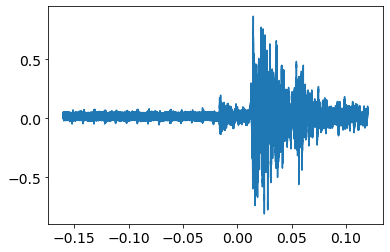

In [26]:
plt.plot(fastdaq_time, raw_piezo)

In [43]:
if SUBTRACT_LED:
    led_on = ev["fastDAQ"]["CAMgate"] < -0.5
    led_switch = np.diff(np.int8(led_on))
    led_switch_on = led_switch == 1
    led_switch_off = led_switch == -1
    led_switch_on_time = fastdaq_time[:-1][led_switch_on]
    led_switch_off_time = fastdaq_time[:-1][led_switch_off]
    
    led_amp, subt_piezo = a0.subtract_led(raw_piezo, fastdaq_time, led_switch_on_time, led_switch_off_time)

    piezo_waveform = subt_piezo
else:
    piezo_waveform = subt_piezo

In [59]:
# ALGORITHM CONFIGURATION

# Frequency sum window [Hz]
corr_lowerf = 1000
corr_upperf = 25000

# Exponential decay time to convolve with spectral sum
tau = 0.0038

In [68]:
# Spectogram on led-subtracted waveform
fr, bn, sp = a0.spectrogram(piezo_waveform, fastdaq_time)

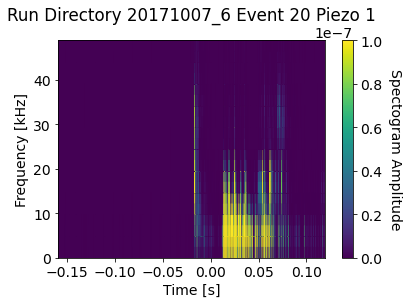

In [69]:
from scipy.fft import fftshift

plt.pcolormesh(t + fastdaq_time.min(), fftshift(fr)[fftshift(fr) < 5e4]/1e3, 
               fftshift(sp, axes=0)[fftshift(fr) < 5e4, :], shading='gouraud', vmin=0, vmax=1e-7)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [kHz]")
cbar = plt.colorbar()
cbar.set_label('Spectogram Amplitude', rotation=270, labelpad=20)

plt.title("Run Directory %s Event %i Piezo %i" % (rundir.split("/")[-1], event, PIEZO), pad=20)

plt.savefig("figures/spectogram_R%s_E%i_P%i.png" % (rundir.split("/")[-1], event, PIEZO))

In [70]:
# Sum the spectrogram within the configured frequency window

sp_sums = a0.spectrum_sums(sp, fr, len(bn), corr_lowerf, corr_upperf)

In [71]:
# Correlate the signal with an exponential fall-off (set by tau)

textent = [min(fastdaq_time), max(fastdaq_time)]
rescaled_t = a0.rescale_window(textent, bn)
corr_dt = np.mean(np.diff(rescaled_t))
corr_n = 1000
_, corr_y = a0.corr_signal(tau, corr_dt, rescaled_t[0], corr_n)

corr = np.correlate(sp_sums, corr_y, "same")
corr_t = rescaled_t - 0.5 * corr_n * corr_dt
corr = np.correlate(sp_sums, corr_y, "same")
corr_t = rescaled_t - 0.5 * corr_n * corr_dt

In [74]:
# Initial t0 finding
test_t0 = a0.find_t0_from_corr(corr_t, corr) # This is the t0 we begin to look backwards from

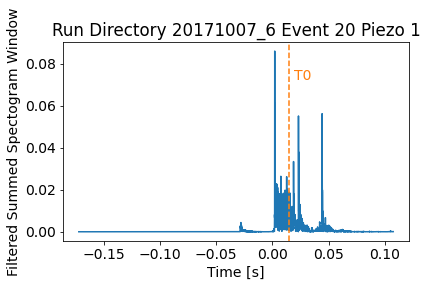

In [81]:
plt.plot(corr_t, sp_sums)
plt.ylabel("Filtered Summed Spectogram Window")
plt.xlabel("Time [s]")
plt.title("Run Directory %s Event %i Piezo %i" % (rundir.split("/")[-1], event, PIEZO))

plt.tight_layout()

plt.axvline(test_t0, color="tab:orange", linestyle="--")
plt.text(test_t0+0.005, plt.ylim()[1]*0.8,  "T0", 
         color="tab:orange", horizontalalignment="left")

plt.savefig("figures/correlated_summed_spectogram_amplitude_R%s_E%i_P%i.png" % (rundir.split("/")[-1], event, PIEZO))

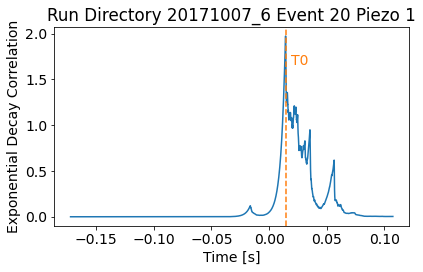

In [82]:
plt.plot(corr_t, corr)
plt.ylabel("Exponential Decay Correlation")
plt.xlabel("Time [s]")
plt.title("Run Directory %s Event %i Piezo %i" % (rundir.split("/")[-1], event, PIEZO))

plt.tight_layout()

plt.axvline(test_t0, color="tab:orange", linestyle="--")
plt.text(test_t0+0.005, plt.ylim()[1]*0.8,  "T0", 
         color="tab:orange", horizontalalignment="left")
plt.savefig("figures/median_correlated_summed_spectogram_amplitude_R%s_E%i_P%i.png" % (rundir.split("/")[-1], event, PIEZO))